Primero voy a simular los datos y graficarlos:

Tasa de eventos (lambda): 8.87
Conteos por intervalo: [100  74  64  71  74  81 100 105  91  94  76  97  88  80  86  98  87  75
 107  95  86  75  98  61  87  94  97  98  92  72]


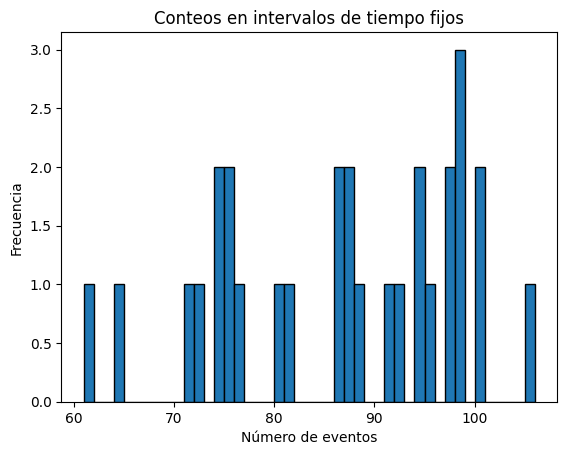

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


###código a borrar###
# generar los valores de tiempo.
valores_tiempo = np.random.normal(loc=0.5, scale=1, size=10)

duracion_intervalo = 10  # segundos
n_intervalos = 30
################################################################

# Dónde poner los valores de tiempo
valores_tiempo = np.array([4.21,3.29,12.09,12.83,7.70,6.96,3.68,18.93,9.66,9.35]) #en seg

# donde poner los conteos de eventos 
conteos_por_intervalo = np.array([5,3,5,8,7,5,5,7,5,3,11,4,13,7,10,4,2,8,11,3,8,5,4,4,3,5,5,7,4,6]) 
#conteos en 9 seg de deteccion para el tubo sin muestras

#americio-241
#[1,8,6,2,1,8,6,11,3,4,2,3,3,6,7,6,9,5,5,2,2,4,4,4,5,9,9,4,4,2]

#torio - barra soldadura
#[3,2,0,7,2,5,6,5,11,4,4,2,5,6,4,2,6,0,1,4,8,1,6,6,6,2,7,2,5,4]

lambda_rate = valores_tiempo.mean()  # eventos por segundo

print("Tasa de eventos (lambda):", lambda_rate)
conteos_por_intervalo = np.random.poisson(lambda_rate * duracion_intervalo, n_intervalos)
print("Conteos por intervalo:", conteos_por_intervalo)
plt.hist(conteos_por_intervalo, bins=range(min(conteos_por_intervalo), max(conteos_por_intervalo)), edgecolor='black')
plt.title("Conteos en intervalos de tiempo fijos")
plt.xlabel("Número de eventos")
plt.ylabel("Frecuencia")
plt.show()

Una vez tenemos los datos, necesitamos hacer el ajuste, el profesor no es muy claro, debemos usar curve_fit? o suponer desde ya que sigue una distribución de Poisson y por tanto solo graficar una con la otra y pasar al test de hipótesis?

Esperar al martes, de todas formas, si consideramos que la datos ya deben seguir una distribución de Poisson y la media que tienen es la media de la distribución:

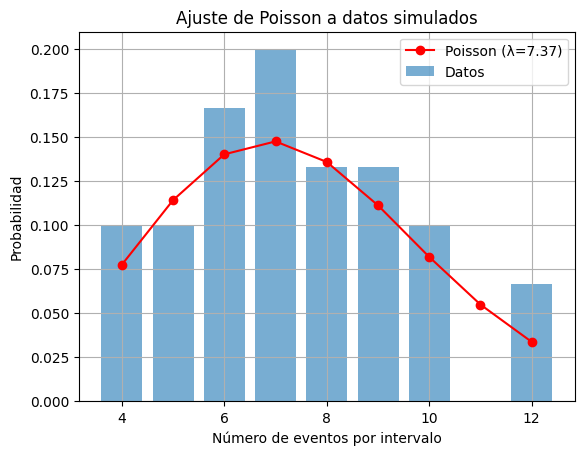

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Histograma de los datos
valores, conteo = np.unique(conteos_por_intervalo, return_counts=True)
plt.bar(valores, conteo / len(conteos_por_intervalo), alpha=0.6, label="Datos")

# Curva de Poisson ajustada
x = np.arange(min(valores), max(valores)+1)
poisson_teorica = poisson.pmf(x, conteos_por_intervalo.mean())
plt.plot(x, poisson_teorica, 'o-', label=f'Poisson (λ={conteos_por_intervalo.mean():.2f})', color='red')

plt.xlabel("Número de eventos por intervalo")
plt.ylabel("Probabilidad")
plt.title("Ajuste de Poisson a datos simulados")
plt.legend()
plt.grid()
plt.show()

Si lo quiere con Curve_fit:

λ ajustada = 7.428


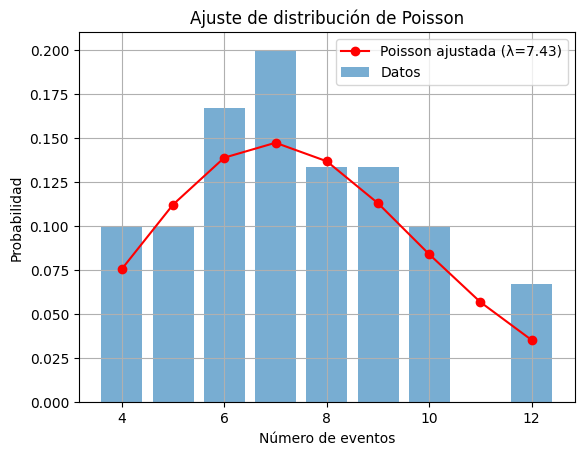

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson



# Histograma: frecuencias absolutas
valores, frecuencias = np.unique(conteos_por_intervalo, return_counts=True)

# Normalizamos para obtener probabilidades
frecuencias = frecuencias / np.sum(frecuencias)

# Definimos la función de Poisson a ajustar
def poisson_pmf(k, lamb):
    return poisson.pmf(k, lamb)

# Ajuste con curve_fit
#a veces hay que poner el valor inicial de lambda, por ejemplo: p0=[1.0] o un valor aproximado del lambda (parámetro), para que no de error
params_opt, params_cov = curve_fit(poisson_pmf, valores, frecuencias) 

# Resultado del ajuste
lambda_ajustada = params_opt[0]
print(f"λ ajustada = {lambda_ajustada:.3f}")

# Graficamos
x = np.arange(min(valores), max(valores)+1)
plt.bar(valores, frecuencias, alpha=0.6, label='Datos')
plt.plot(x, poisson_pmf(x, lambda_ajustada), 'o-', color='red', label=f'Poisson ajustada (λ={lambda_ajustada:.2f})')

plt.xlabel("Número de eventos")
plt.ylabel("Probabilidad")
plt.title("Ajuste de distribución de Poisson")
plt.legend()
plt.grid()
plt.show()

Con la prueba de chisquare vamos a tener el mismo problema, sobre qué curva hacemos la prueba de hipótesis? la de curve_fit? o la que arrojan los datos?

Hagamos primero con la que arrojan los datos:

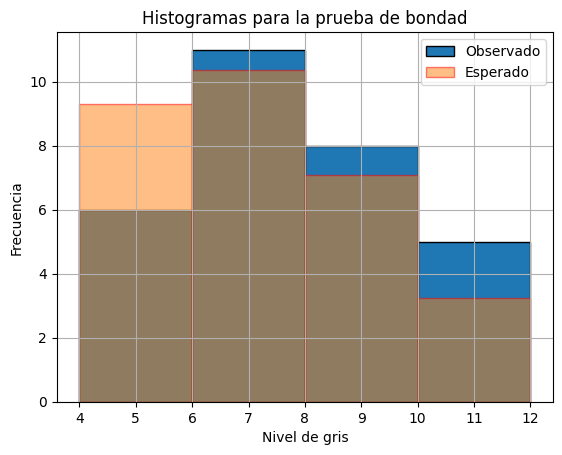

media = 7.37
El valor de chi2 es 2.29 y el valor p es 51.4 %. El número de intervalos es 4


In [ ]:
from scipy.stats import poisson, chisquare

def pruebaBondad(datos):
        image = datos
        mu = image.mean()
        max_bins = 50
        bins = max_bins

        while bins > 1:
            counts, bin_edges = np.histogram(image, bins=bins)
            if all(counts >= 5):
                break
            bins -= 1

        # Paso 2: calcular observados y esperados
        observed, _ = np.histogram(image, bins=bin_edges)

        # Calcular frecuencias esperadas usando la distribución exponencial negativa acumulada
        cdf_values = poisson.cdf(bin_edges, mu)
        expected = np.diff(cdf_values) * len(image)
        # Normalizar esperados
        expected = expected * (observed.sum() / expected.sum())

        # Calcular las posiciones centrales de los bins
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Graficar
        plt.bar(bin_centers, observed, width=np.diff(bin_edges), edgecolor='black',label='Observado')
        plt.bar(bin_centers, expected, width=np.diff(bin_edges), edgecolor='red',alpha=0.5,label='Esperado')
        plt.xlabel("Nivel de gris")
        plt.ylabel("Frecuencia")
        plt.title("Histogramas para la prueba de bondad")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Paso 3: aplicar prueba chi-cuadrado
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

        print('media = {:.2f}'.format(mu))
        print('El valor de chi2 es {:.2f} y el valor p es {:.1f} %. El número de intervalos es {}'.format(chi2_stat, 100*p_value,bins))
pruebaBondad(conteos_por_intervalo)


Luego con la que arroja curve_fit

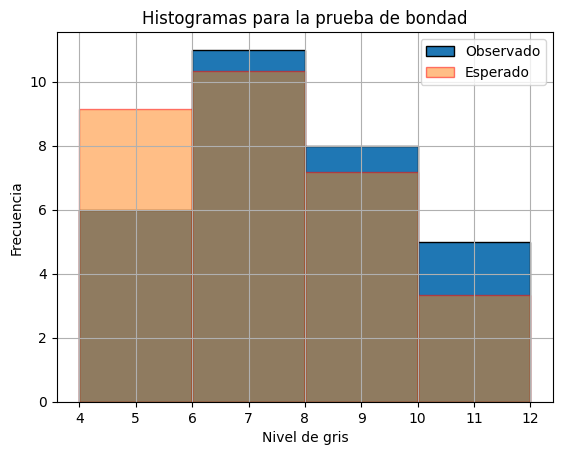

media = 7.43
El valor de chi2 es 2.04 y el valor p es 56.3 %. El número de intervalos es 4


In [33]:
from scipy.stats import poisson, chisquare

def pruebaBondad(datos):
        image = datos
        mu = lambda_ajustada
        max_bins = 50
        bins = max_bins

        while bins > 1:
            counts, bin_edges = np.histogram(image, bins=bins)
            if all(counts >= 5):
                break
            bins -= 1

        # Paso 2: calcular observados y esperados
        observed, _ = np.histogram(image, bins=bin_edges)

        # Calcular frecuencias esperadas usando la distribución exponencial negativa acumulada
        cdf_values = poisson.cdf(bin_edges, mu)
        expected = np.diff(cdf_values) * len(image)
        # Normalizar esperados
        expected = expected * (observed.sum() / expected.sum())

        # Calcular las posiciones centrales de los bins
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Graficar
        plt.bar(bin_centers, observed, width=np.diff(bin_edges), edgecolor='black',label='Observado')
        plt.bar(bin_centers, expected, width=np.diff(bin_edges), edgecolor='red',alpha=0.5,label='Esperado')
        plt.xlabel("Nivel de gris")
        plt.ylabel("Frecuencia")
        plt.title("Histogramas para la prueba de bondad")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Paso 3: aplicar prueba chi-cuadrado
        chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

        print('media = {:.2f}'.format(mu))
        print('El valor de chi2 es {:.2f} y el valor p es {:.1f} %. El número de intervalos es {}'.format(chi2_stat, 100*p_value,bins))
pruebaBondad(conteos_por_intervalo)

Repetir esto con los datos arrojados con las muestras no es difícil, solo cambiar los valores de conteos y sale.